In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt 
import jax.numpy as jnp
from jax import random
from numpyro.infer import Predictive
from reusable.util import load_samples, gen_file_name, get_decoder_params, load_args, load_training_state, save_samples, load_training_history
from reusable.gp import BuildGP
from reusable.mcmc import vae_mcmc, run_mcmc
from reusable.geo import load_state_centroids
from plotting.plots import plot_draws, compare_draws, plot_one_inference
from plotting.ny import plot_multi_on_state, plot_on_state, mask_for_plotting
import numpyro
from reusable.split import calculate_obs_fracs, calculate_spatial_cv, generate_split_titles
numpyro.set_host_device_count(4)
import numpy as onp


/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_324998/2153711017.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/

In [18]:
args = load_args(19, 1, 6) # 7 for day 127
rng_key = random.PRNGKey(3)
if "n" not in args:
    args["n"] = args["x"].shape[0]

    
rng_key, rng_key_init, rng_key_init_state, rng_key_plots = random.split(rng_key, 4)


In [23]:

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    try:
        metrics_hist = load_training_history(args["expcode"], gen_file_name(args["expcode"], args, loss_fn))
        t= metrics_hist["epoch_times"][-1] 
        print(loss_fn, f"{t} s =  {t/60} min = {t/3600}hrs " )
    
    except FileNotFoundError:
        continue


RCL+KLD 607.5045897960663 s =  10.125076496601105 min = 0.16875127494335174hrs 
0.01RCL+KLD+10mmd_rbf_sum-4.0 25191.68417572975 s =  419.8614029288292 min = 6.99769004881382hrs 


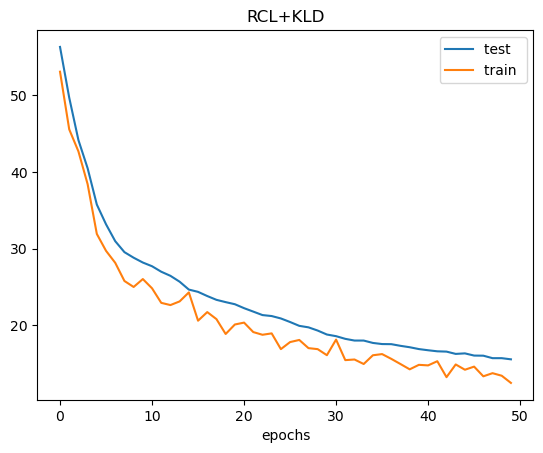

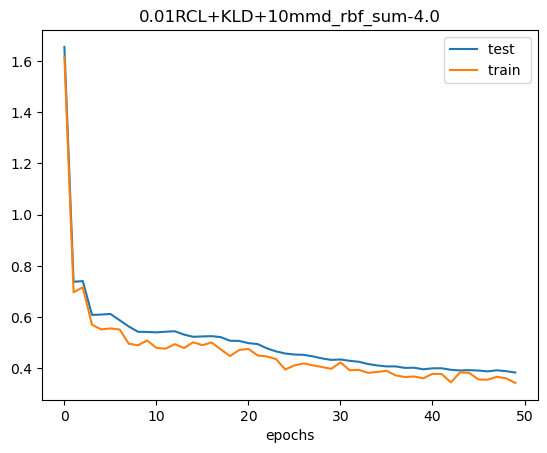

In [15]:
from plotting.plots import plot_training



for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    try:
        metrics_hist = load_training_history(args["expcode"], gen_file_name(args["expcode"], args, loss_fn))
        plot_training(metrics_hist["test_loss"], metrics_hist["train_loss"], loss_fn)
    
    except FileNotFoundError:
        continue


## Comparing GP to PriorVAE draws

In [16]:
should_load_samples = True
to_plot = 200

data_file_name = gen_file_name(args["expcode"], args, f"gp_plot_{to_plot}", data_only=True)

if should_load_samples:
    gp_plot_samples = load_samples(19, data_file_name)
else:
    
    gp = BuildGP(
            args["gp_kernel"],
            noise=False,
            length_prior_choice=args["length_prior_choice"],
            length_prior_args=args["length_prior_arguments"],
            variance_prior_choice=args["variance_prior_choice"],
            variance_prior_args=args["variance_prior_arguments"],
        )

    print("Starting GP")

    gp_plot_pred = Predictive(gp, num_samples=to_plot)
    gp_plot_samples = gp_plot_pred(rng_key_plots, args["x"], jitter=5e-5)

    print("Done GP")
    save_samples(args["expcode"], data_file_name , gp_plot_samples)

In [13]:
from plotting.plots import compare_draws
from reusable.vae import VAE
import optax
from reusable.train_nn import SimpleTrainState

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["x"].shape[0],
    conditional=True,
)
params = module.init(rng_key_init, jnp.ones((args["batch_size"], args["n"],)))[
    "params"
]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
dummy_state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key=rng_key_init_state)

# samples = {}

# for loss_fn in args["loss_fn_names"]:
#     if loss_fn == "gp":
#         continue
#     file_name = gen_file_name(args["expcode"], args, loss_fn, "C")

#     decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))   

#     vae=vae_mcmc(
#             args["hidden_dim1"],
#             args["hidden_dim2"],
#             args["latent_dim"],
#             decoder_params,
#             obs_idx=None,
#             noise=False,
#         )

    

#     cvae_plot_pred = Predictive(vae, num_samples=to_plot)
#     samples[loss_fn] = cvae_plot_pred(rng_key_plots, args["x"], jitter=5e-5)
#     compare_draws(
#         jnp.arange(0, args["x"].shape[0]),
#         gp_plot_samples["y"],
#         samples[loss_fn]["f"],
#         "GP priors on NY, drawn on a line!",
#         f"{loss_fn} VAE priors on NY",
#         "stupid",
#         "stupid",
#         "GP",
#         "VAE",
#         _min=-40,
#         _max=40
#     )

2 4
(8, 1794)
2 4
(8, 1794)
2 4


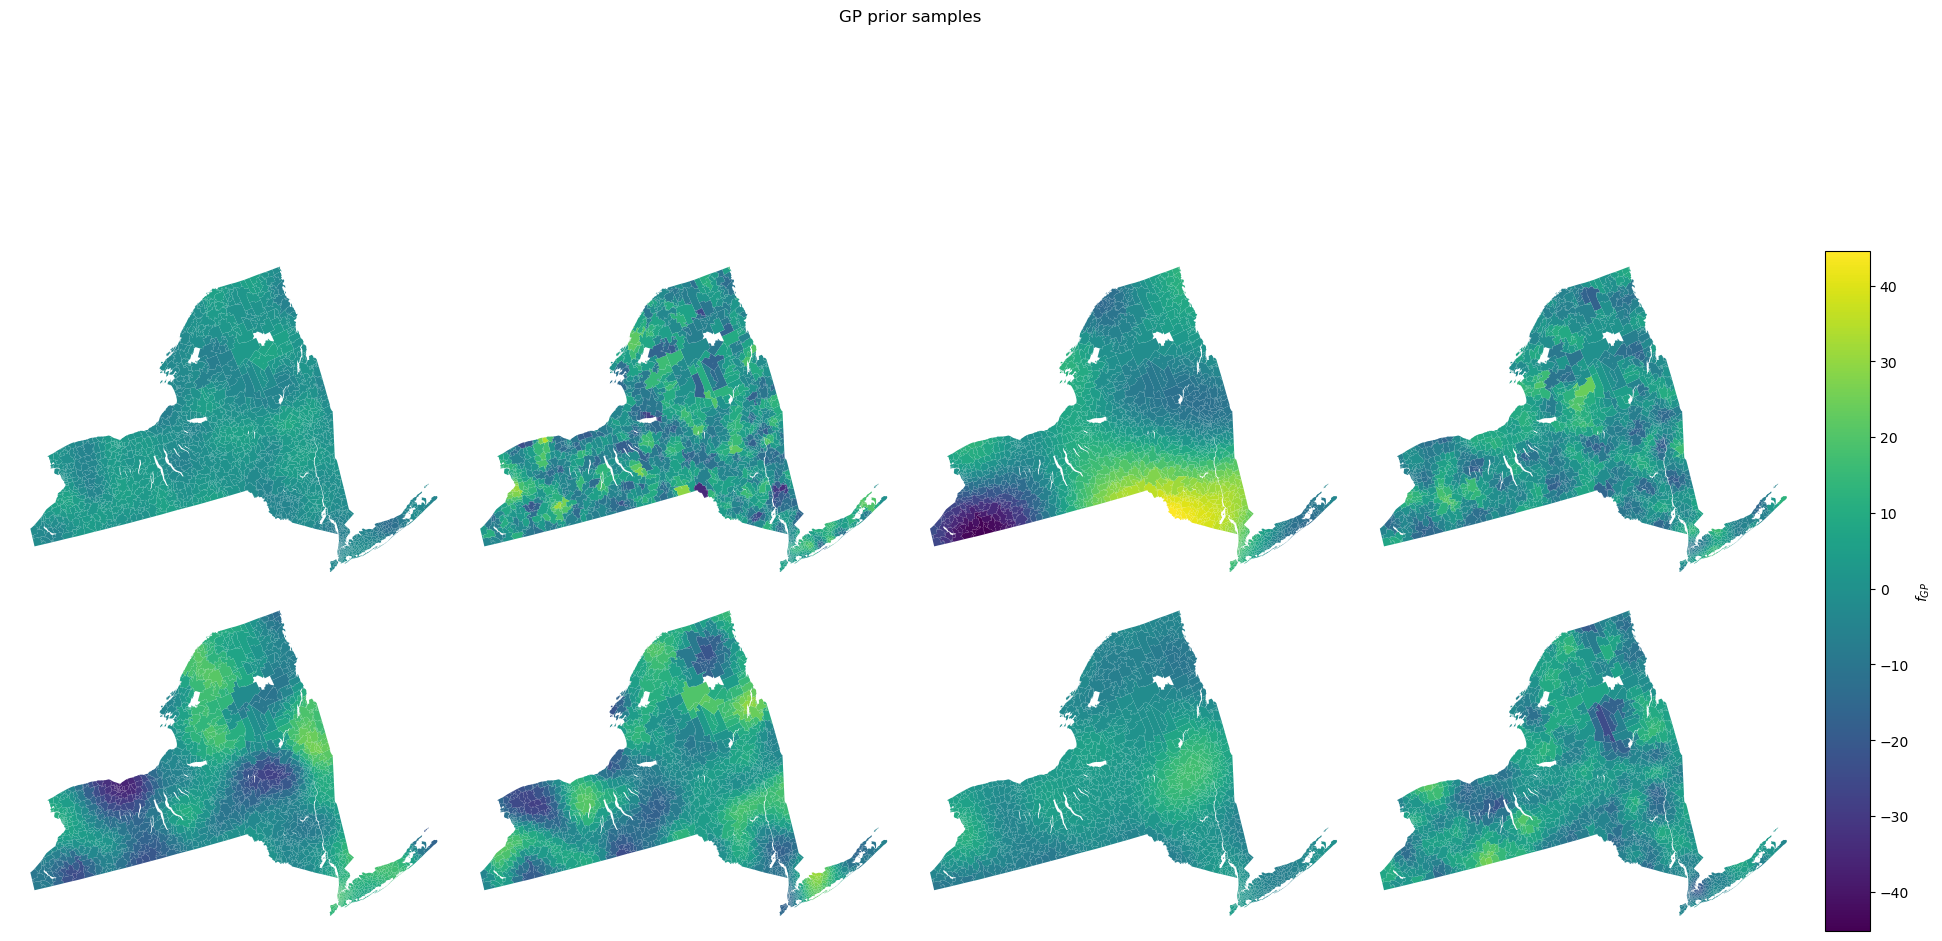

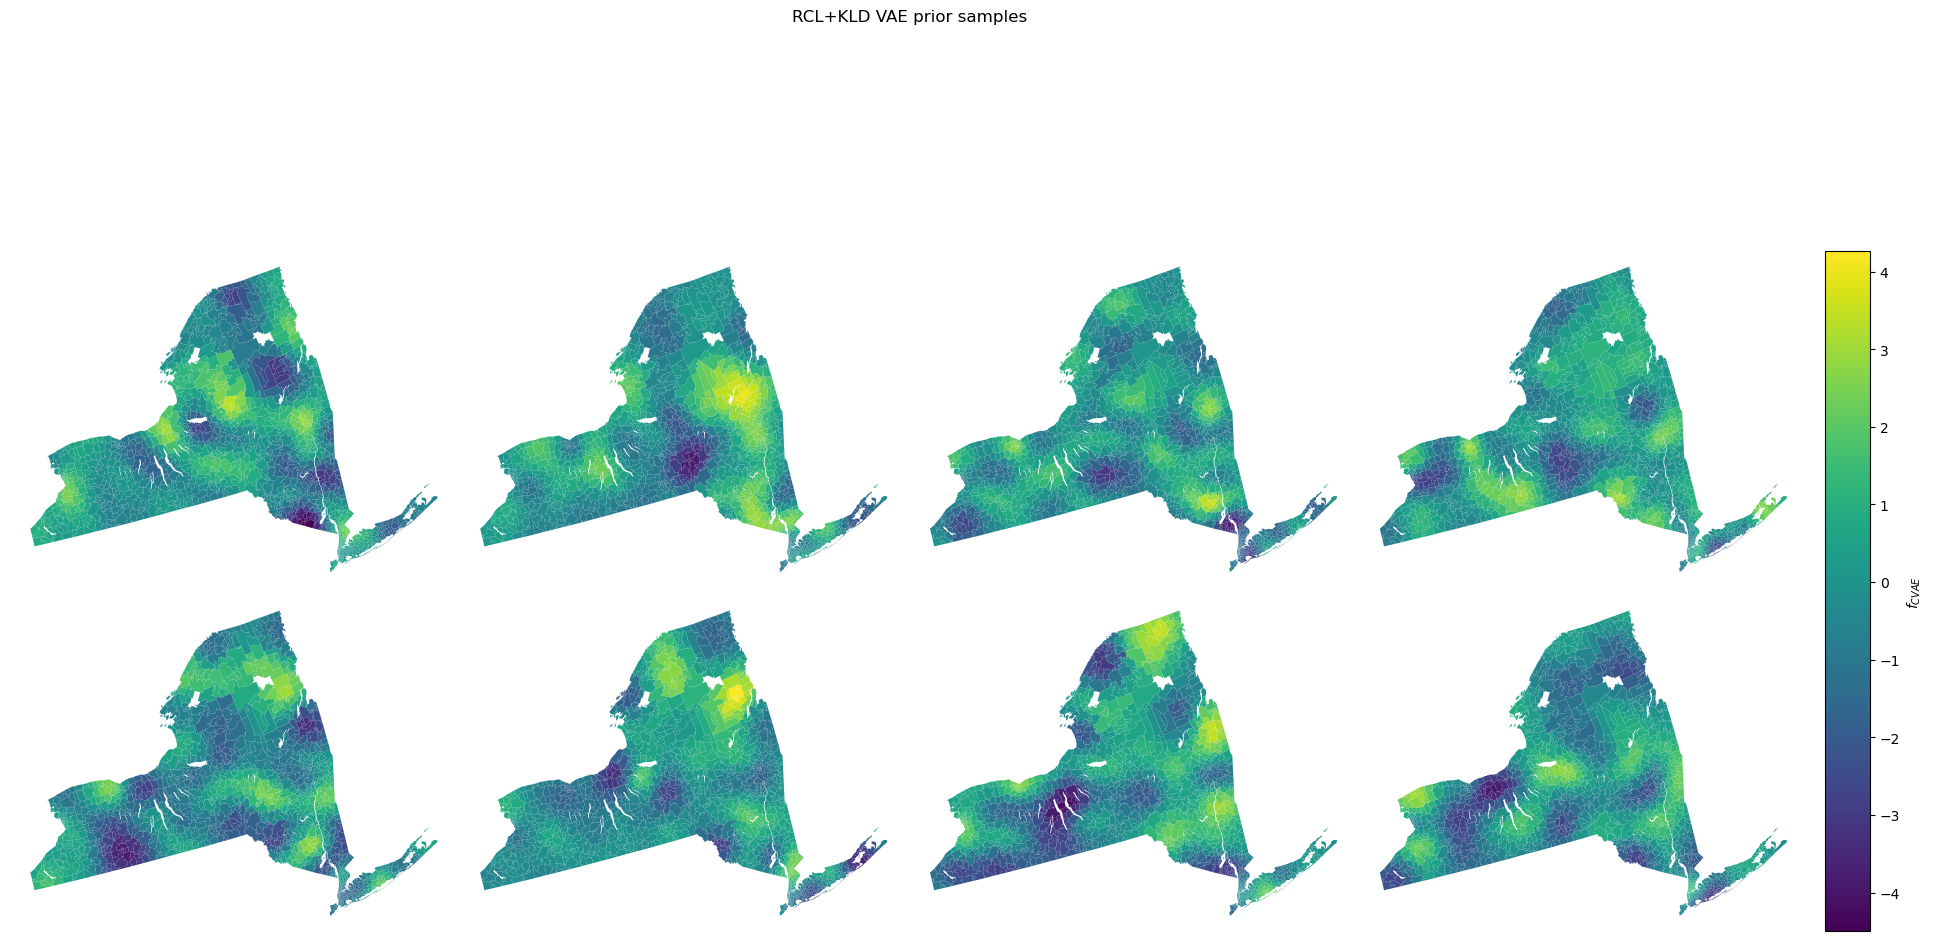

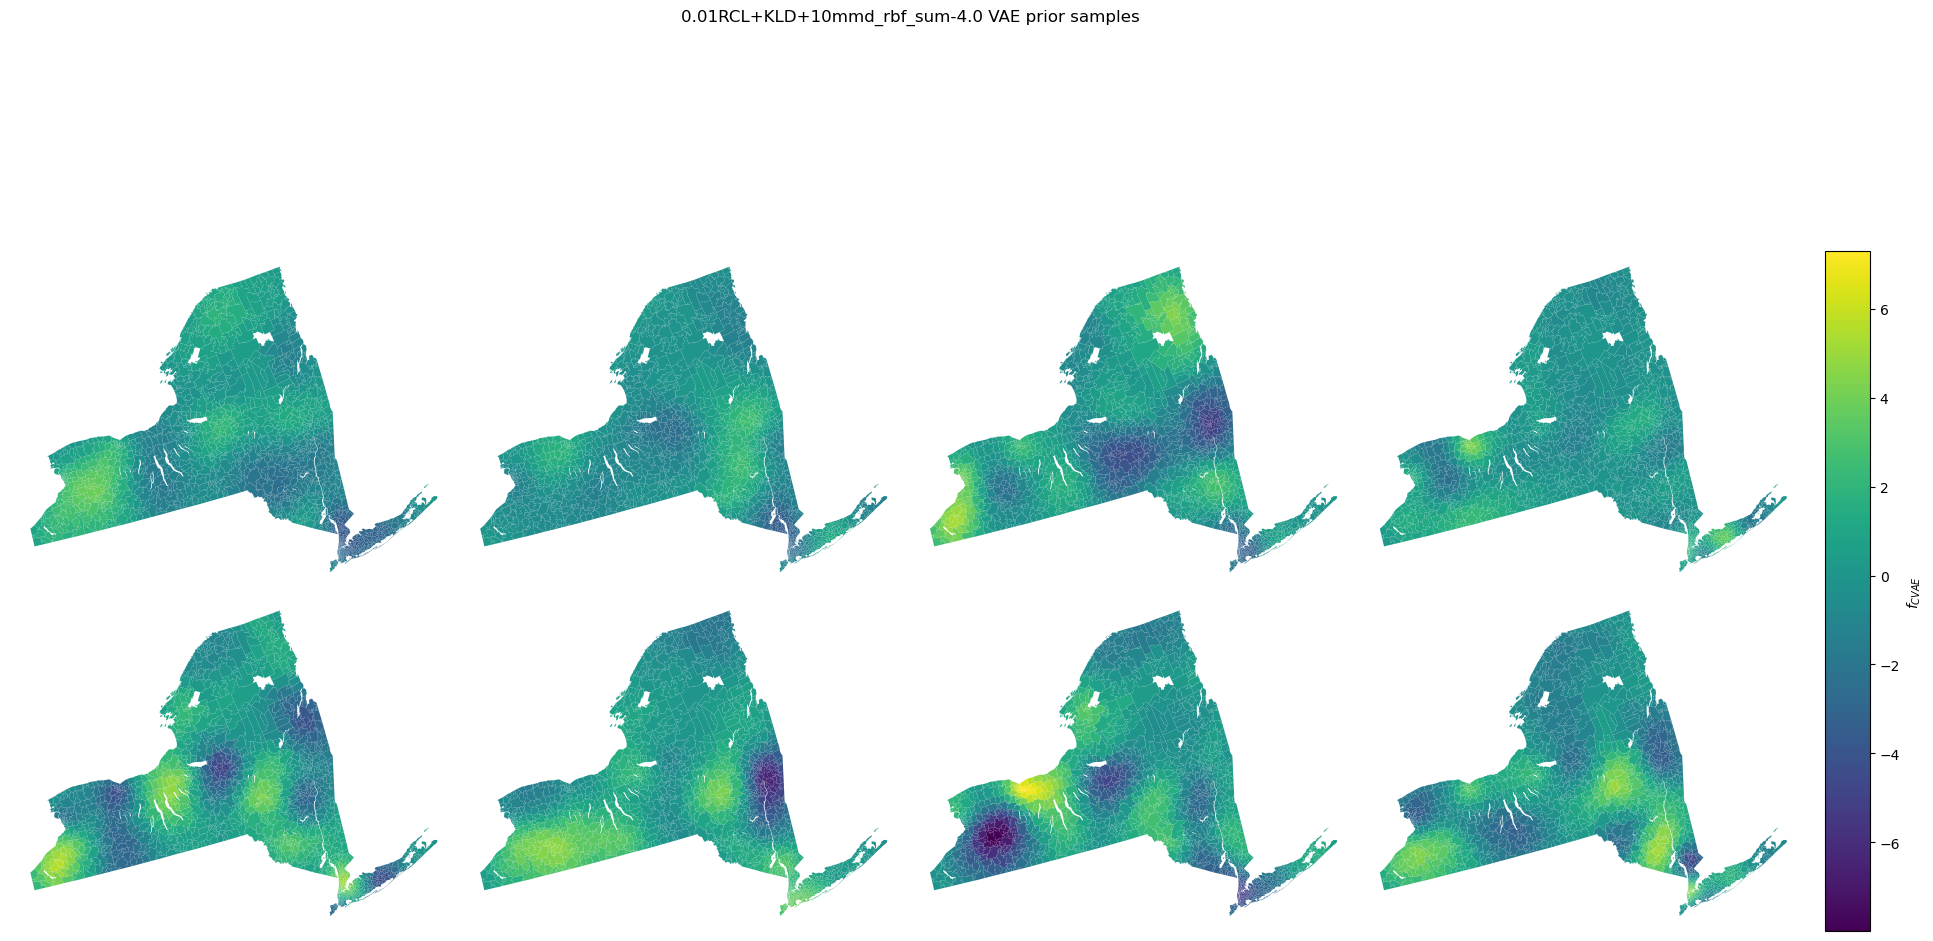

In [6]:
plot_multi_on_state(gp_plot_samples["y"][:8], args["state"], "$f_{GP}$", "GP prior samples")

for loss_fn in args["loss_fn_names"]:
    if loss_fn == "gp":
        continue
    print(samples[loss_fn]["f"][:8].shape)
    plot_multi_on_state(samples[loss_fn]["f"][:8], args["state"], "$f_{CVAE}$", f"{loss_fn} VAE prior samples", )


### Ground truth

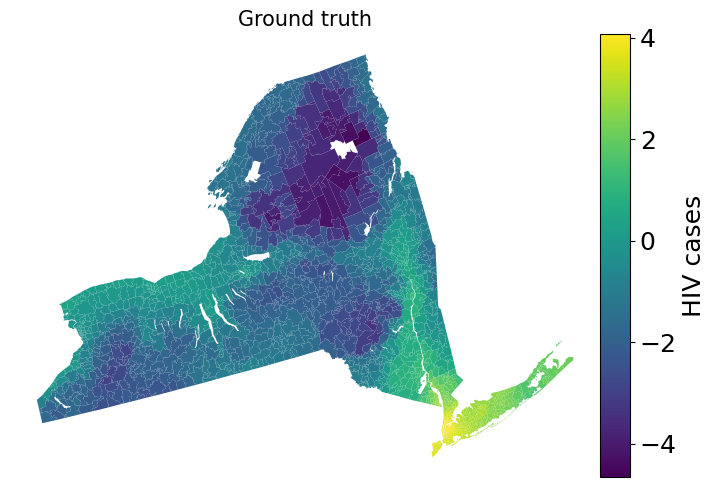

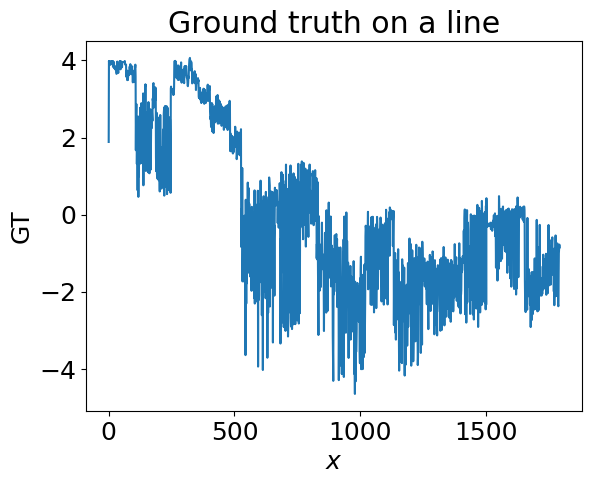

In [19]:
plot_on_state(args["ground_truth"], args["state"], "HIV cases", "Ground truth" )
plot_draws(args["ground_truth"][None], jnp.arange(args["n"]), "Ground truth on a line", "GT")

### Inference

In [8]:
rng_key_observations, rng_key_spatial_cv = random.split(args["observations_rng_key"], 2)


state_centroids = load_state_centroids(args["state"])
obs_idx_lst = calculate_obs_fracs(args["obs_fracs"], args["n"], rng_key_observations) + calculate_spatial_cv(
    args["num_cv_splits"], state_centroids["geometry"], args["n"], rng_key_spatial_cv
)
titles = generate_split_titles(args["obs_fracs"], args["n"], args["num_cv_splits"])

del state_centroids

/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2 5


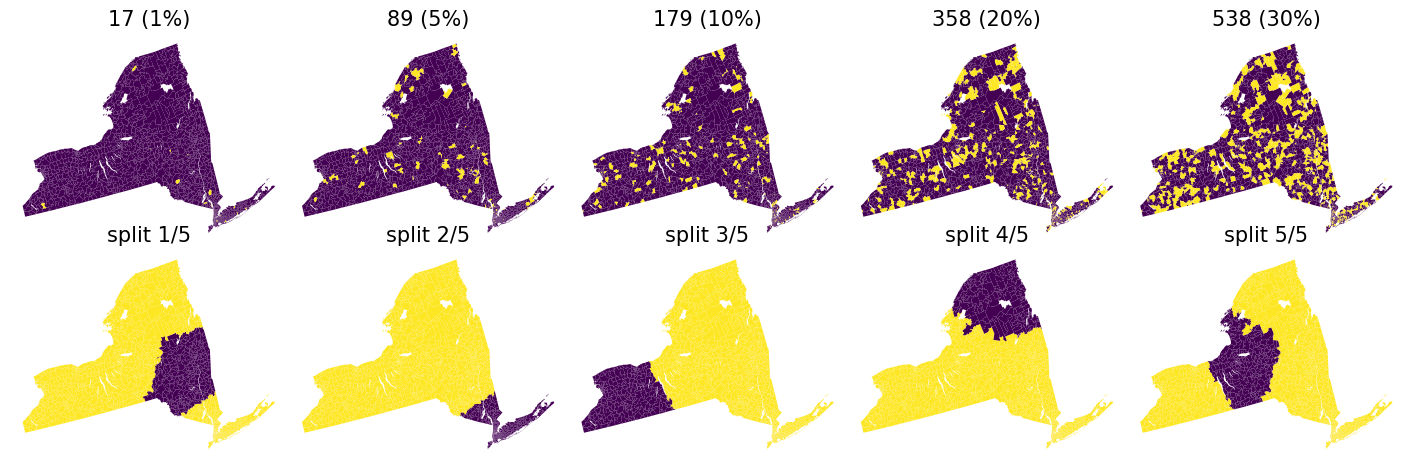

In [17]:
masks = []
for x in obs_idx_lst:
    t = onp.zeros(args["n"])
    t[x] = 1
    masks.append(t)

plot_multi_on_state(
            onp.array(masks),
            36,
            None,
            None,
            titles,
            save_file_name="19/" + gen_file_name(19, args, "obs_points"),
            num_in_row=5,
            show_cbar=False,
        )

3 5
2 5
3 5
2 5


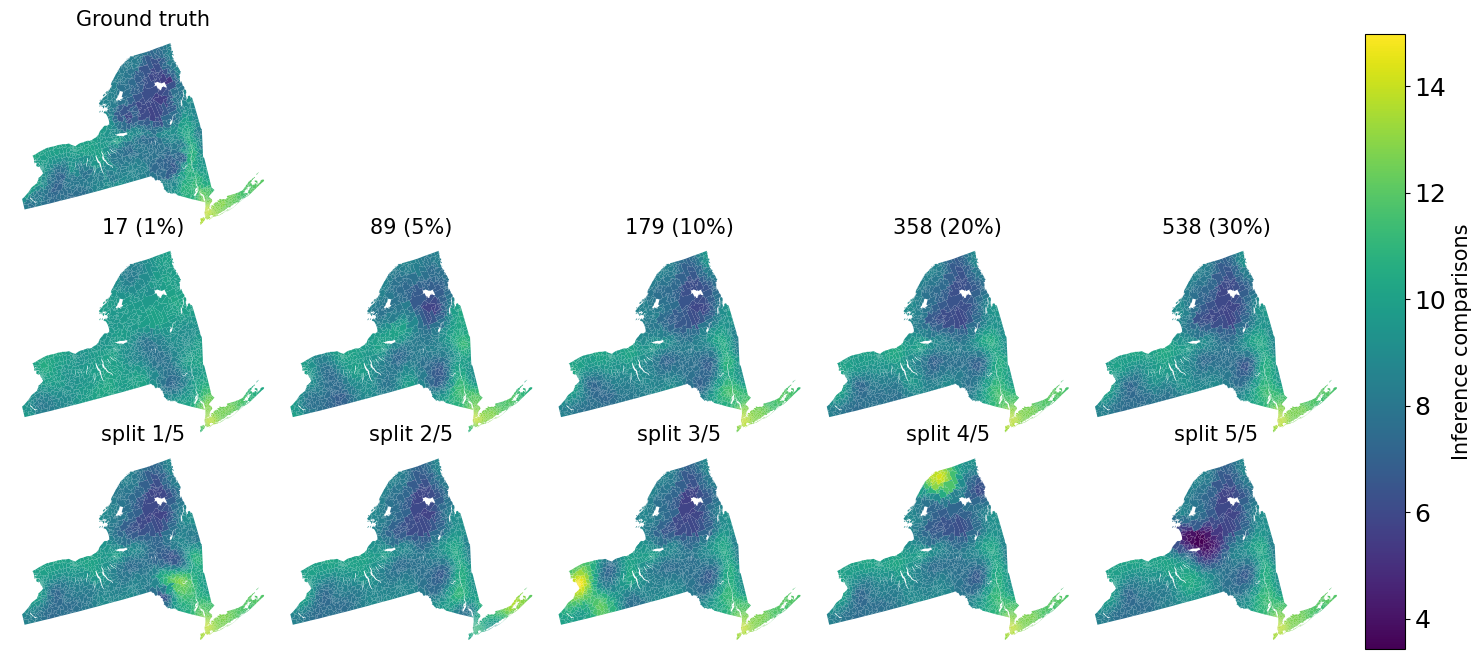

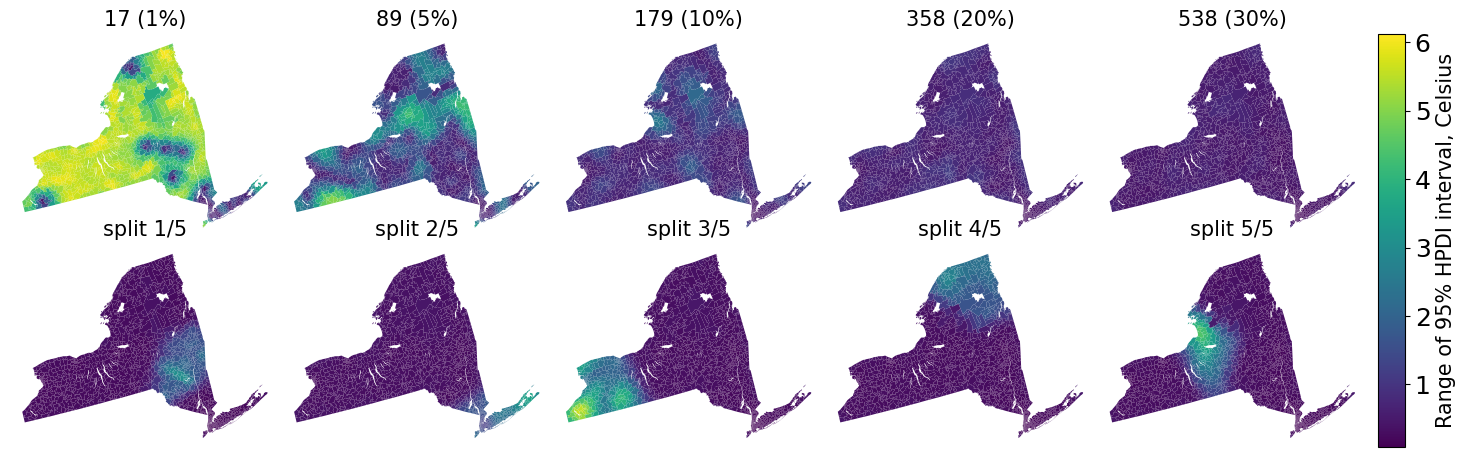

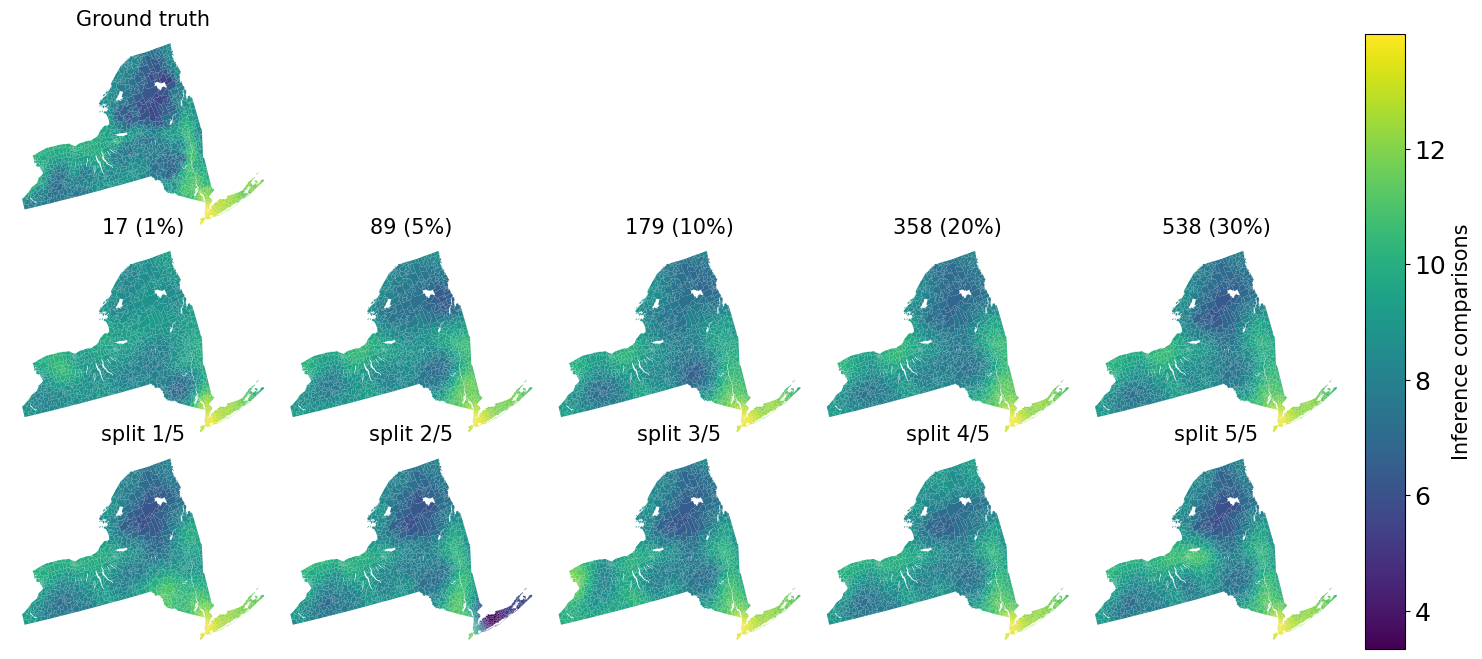

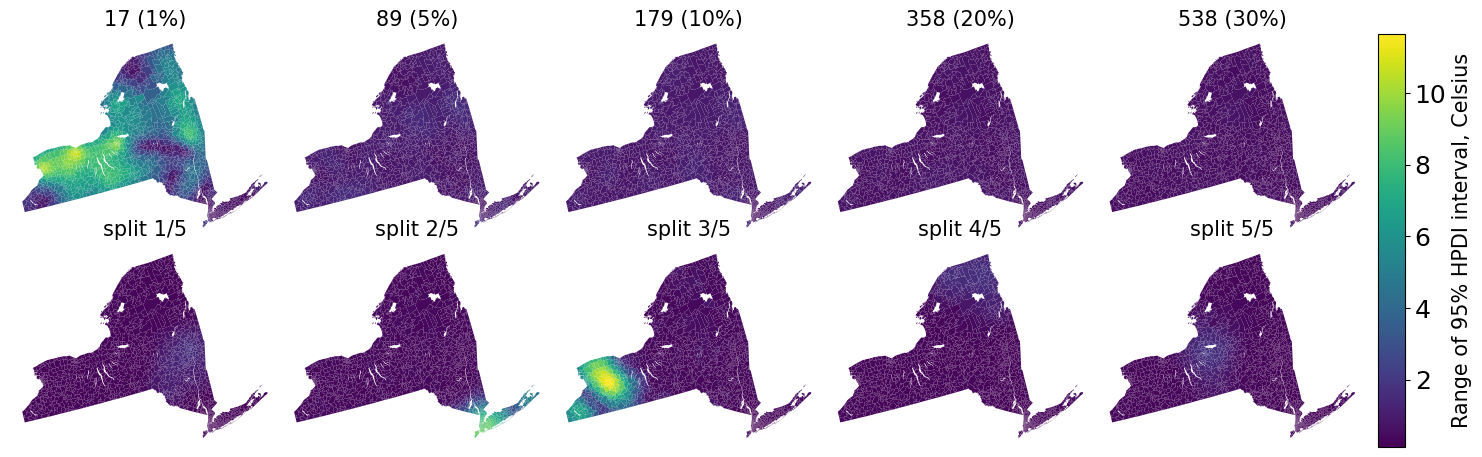

In [20]:
rng_key_predict = random.PRNGKey(344)

for loss_fn in args["loss_fn_names"]:
    
    file_name = gen_file_name(args["expcode"], args, loss_fn, "C")

    if loss_fn == "gp":
        continue

    label = f"{loss_fn}"
    # comment out for 36_2010_mean!!!
    #label += f"{args['state']}_{args['year']}_{args['aggr_method']}"

    means = []
    lowers = []
    uppers = []

    for i, obs_idx in enumerate(obs_idx_lst):
        decoder_params = get_decoder_params(load_training_state(args["expcode"], file_name, dummy_state))
        v = vae_mcmc(
            args["hidden_dim1"],
            args["hidden_dim2"],
            args["latent_dim"],
            decoder_params,
            obs_idx=obs_idx,
            noise=True,
        )

        mcmc_samples = load_samples(
            args["expcode"],
            gen_file_name(args["expcode"], args, f"inference_{label}_split{i}_mcmc", include_mcmc=True),
        )

        

        predictive = Predictive(v, mcmc_samples)
        plot_samples = predictive(
            random.fold_in(rng_key_predict, i),
            args["x"],
        )["f"]

        del mcmc_samples

        mean = jnp.mean(plot_samples, axis=0)
        hpdi = numpyro.diagnostics.hpdi(plot_samples, 0.95)
        lowers.append(hpdi[0])
        uppers.append(hpdi[1])
        means.append(mean)

    plot_multi_on_state(
        onp.array([args["ground_truth"]] + means) + args["temp_mean_offset"],
        36,
        "Inference comparisons",
        None,
        ["Ground truth"] + titles,
        num_in_row=5,
        save_file_name="19/" + gen_file_name(19, args, f"{label}_observed_means"),
        backfill="align_left",
    )

    plot_multi_on_state(
        onp.array([u - l for u, l in zip(uppers, lowers)]),
        36,
        "Range of 95% HPDI interval, Celsius",
        None,
        titles,
        save_file_name="19/" + gen_file_name(19, args, f"{label}_hpdi_diffs"),
        num_in_row=5,
    )
